# Abschätzung der Wahrscheinlichkeit für eine 'überkritische' Undichtigkeiten im (Bio-)Reaktor

_basiert auf Diskussion mit W. Storhas im Dezember 2022_

**Annahmen:**
* Die Anzahl $N$ der Poren/Undichtigkeiten im Reaktor ist unbekannt und zufällig verteilt [1].
* Vorerst: $N$ ist Poisson-verteilt mit bekanntem Erwartungswert $\lambda$.
* Einzelne Porenflächen $A_i$ sind ebenfalls zufällig verteilt, und zwar unabhängige und identisch ('i.i.d.'). D.h. $A_i \sim A$ bei **bekannter Verteilung** von $A$.
* Vorerst: Annahme einer Normalverteilung für $A$, mit bekanntem Erwartungswert $\mathbb E(A)=\mu$ und bekannter Standardabweichung $\textrm{Var}(A)=\sigma$.
* Gesamtfläche $A_\textrm{tot}=\sum_{i=1}^{N} $ ist durch Messung des Druckabfalls bestimmbar (vorerst: Vernachlässigung des Messfehlers von $A_\textrm{tot}$, d.h. exakte Bestimmung)
* Alle Längen in µm, Flächen in µm2
[1] hypothetische Grundgesamtheit: alle Reaktoren dieses konkreten Reaktortyps

**Gesucht:**
Bedingte Wahrscheinlichkeit dafür, dass größte Pore (mit Fläche $A_\textrm{max}=\max_{i=1}^{N} A_i$) größer als gegebene kritische Fläche $A_\textrm{krit}$ ist, wenn die Gesamtfläche $A_\textrm{tot}$ einen gegebenen (gemessenen) Wert hat.

## Teil I: Numerische Monto-Carlo-Simulation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, gaussian_kde

In [8]:
# Parameter lambda für Verteilung der Porenanzahl (entspricht dem Erwartungswert für Porenzahl)
lambda_list = [5, 10, 50] # Liste möglicher Werte
#lambda_list = np.linspace(0.1, 10, 101) # Liste möglicher Werte

# Parameter des Porenfläche mu, sigma (Erwartungswert, Std.abweichung) in µm^2
mean_d, sigma_d = 0.1, 0.07 # Werte bezogen auf Durchmesser
mu, sigma = mean_d**2*np.pi/4, sigma_d**2*np.pi/4 # Werte bezogen auf Fläche

# Simulationsparameter
M = int(1e4) # Anzahl Monte Carlo samples (= hypothetische Reaktoren)

# kriticher Durchmesser / Fläche
d_crit = .13 # krit. Durchmesser in µm
A_crit = d_crit**2*np.pi/4

print('Porenfläche [µm2] = {:f} +- {:f} (1 sigma); Kritische Porenfläche [µm2] = {:f}; z-Score der kritischen Porenfläche = {:f}'.format(mu, sigma, A_crit, (A_crit - mu)/sigma))

Porenfläche [µm2] = 0.007854 +- 0.003848 (1 sigma); Kritische Porenfläche [µm2] = 0.013273; z-Score der kritischen Porenfläche = 1.408163


In [9]:
# Simuliere M Reaktoren und ihre Gesamtporenfläche

A_tot = dict()
A_max = dict()

for lam in lambda_list:
    # set up random number generator
    rnd = np.random.default_rng(seed=7483)

    # draw random no. of pores
    n_vals = rnd.poisson(lam, size=M)
    n_max = n_vals.max()

    # draw random pore area
    A_i = np.random.normal(mu, sigma, (M, n_max))
    #A_i[A_i<0]=0

    # set A_ij = 0 if pore index (j) exceeds no of porse (n_vals[i]) for this realization (i)
    for j in range(n_max):
            A_i[j+1>n_vals,j] = 0

    # calc total and max area for each realization
    A_tot['$\lambda$={}'.format(lam)] = A_i.sum(axis=1)
    A_max['$\lambda$={}'.format(lam)] = A_i.max(axis=1)
    
A_tot_array = np.array(list(A_tot.values())).T
A_max_array = np.array(list(A_max.values())).T


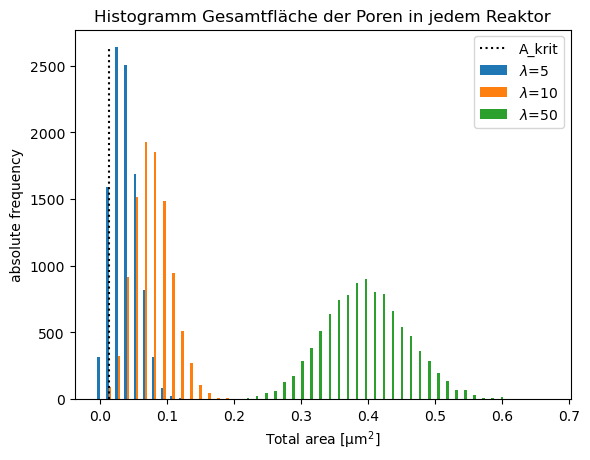

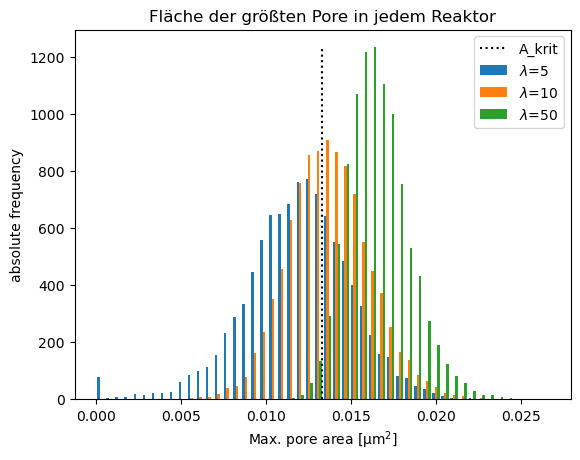

In [10]:
# Histogramme für Gesamt- und Maximalfläche
n_bins = 50

plt.figure()
plt.title("Histogramm Gesamtfläche der Poren in jedem Reaktor")
hist_tot = plt.hist(A_tot_array, bins=n_bins, density=False)
plt.xlabel('Total area [µm$^2$]')
plt.ylabel('absolute frequency')
plt.vlines(A_crit, 0, hist_tot[0].max(), colors='k', linestyles='dotted')
plt.legend(['A_krit'] + list(A_tot.keys()))

plt.figure()
plt.title("Fläche der größten Pore in jedem Reaktor")
hist_max = plt.hist(A_max_array, bins=n_bins)
plt.xlabel('Max. pore area [µm$^2$]')
plt.ylabel('absolute frequency')
plt.vlines(A_crit, 0, hist_max[0].max(), colors='k', linestyles='dotted')
plt.legend(['A_krit'] + list(A_max.keys()))


**comment:**
peaks at area=0 comes from MC samples where n=0 pores was drawn from the Poisson distribution...

### Gemeinsame Verteilung von A_tot und A_krit darstellen

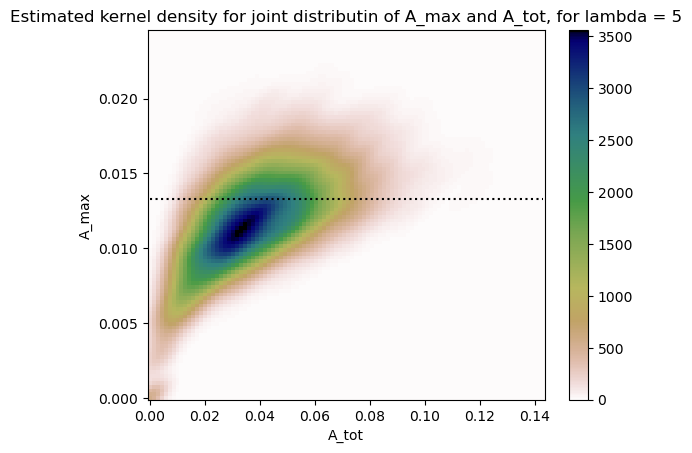

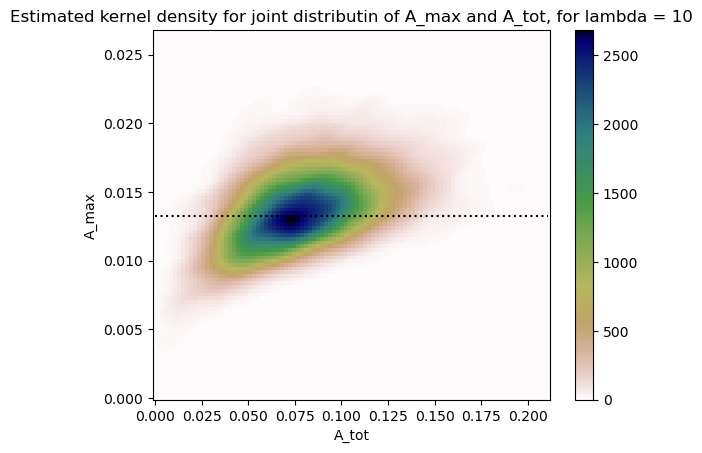

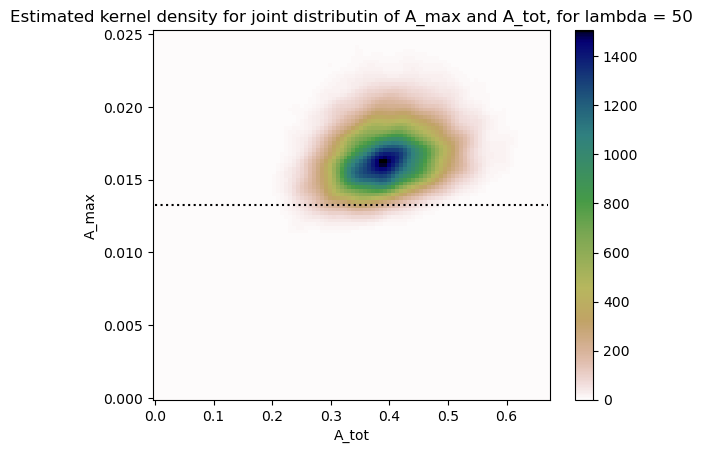

In [11]:
for k in range(len(lambda_list)):

    lam = lambda_list[k]

    X = A_tot_array[:,k]
    Y = A_max_array[:,k]
    data = np.vstack([X, Y])

    #kernel = gaussian_kde(data, .08)
    kernel = gaussian_kde(data)
    Xgrid, Ygrid = np.mgrid[0:X.max():100j, 0:Y.max():100j]# plot kernel density estimation in 2D
    positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
    Z = np.reshape(kernel(positions).T, Xgrid.shape)

    plt.figure()
    plt.pcolormesh(Xgrid, Ygrid, Z, cmap=plt.cm.gist_earth_r)
    plt.hlines(A_crit, 0, X.max(), colors='k', linestyles='dotted')
    plt.xlabel('A_tot')
    plt.ylabel('A_max')
    plt.colorbar()
    plt.title('Estimated kernel density for joint distributin of A_max and A_tot, for lambda = {}'.format(lam))

### Bedingte Wahrscheinlichkeitsverteilung P(A_max > A_crit | A_tot) berechnen

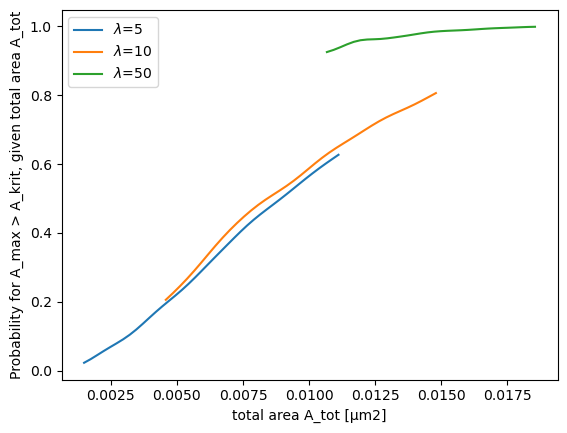

In [12]:

for k in range(len(lambda_list)):

    lam = lambda_list[k]

    X = A_tot_array[:,k]
    Y = A_max_array[:,k]
    data = np.vstack([X, Y])

    #kernel = gaussian_kde(data, .08)
    kernel = gaussian_kde(data)
    Xgrid, Ygrid = np.mgrid[0:X.max():100j, 0:Y.max():100j]

    """
    # plot kernel density estimation in 2D
    positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
    Z = np.reshape(kernel(positions).T, Xgrid.shape)
    plt.matshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
    plt.xlabel('A_tot')
    plt.ylabel('A_max')
    """
    
    # compute the conditional prob. P(A_max > A_crit | A_tot)
    # prior prob.: P(A_tot)
    prior = np.array([kernel.integrate_box(
        [ Xgrid[i  ,0],-np.inf ],
        [ Xgrid[i+1,0], np.inf ]
        ) for i in range(Xgrid.shape[0]-1)])
    # joint prob.: P(A_max > A_crit AND A_tot)
    joint = np.array([kernel.integrate_box(
        [ Xgrid[i  ,0], A_crit ],
        [ Xgrid[i+1,0], np.inf ]
        ) for i in range(Xgrid.shape[0]-1)])
    # condition prob.: P(A_max > A_crit | A_tot)
    cond = np.divide(joint, prior + np.finfo(float).eps)
    cond[prior < 100 / M] = np.nan
    
    ##plt.semilogy(np.sqrt(Ygrid[0,:-1]*4/np.pi), cdf_cond).ylim([1e-3,1])
    ##plt.xlabel('equivalent diameter of total area [µm]')
    #plt.plot(np.sqrt(Ygrid[0,:-1]*4/np.pi), cond)
    #plt.xlabel('equivalent diameter of total area [µm]')
    plt.plot(Ygrid[0,:-1], cond)
    plt.xlabel('total area A_tot [µm2]')
    plt.ylabel('Probability for A_max > A_krit, given total area A_tot')
    
plt.legend(A_max.keys())


**Diskussion:** Der obige plot zeigt die gesuchte Information: Gegeben A_tot (durch Messung), was ist die Wahrscheinlichkeit dafür, das die größte Pore größer als A_krit ist?

## Part II: Theory (not finished!)

* Calculate distribution of $A_{tot}$
* Maximum Likelihood estimation of $\lambda$
* calculation of posterior of $A_{max}$ with observed $A_{tot}$

next step would be to compute distribution A_max from order statistics of normal distribution, and the to compute conditional p. P(A_max = a | A_tot = A_observed)

But critical problem is that expected no. of pores $\lambda$ remains unknown, and for given $A_{tot}$ (from observation), all conclusions severely depend on $\lambda$...

My strong feeling is, that the most likely value for the number of pores $n$ is
$\hat n = A_{observed} / \mu$, maybe with rounding to nearest integer value.
(Here, $\mu$ is the assumed mean area of a pore.) So in the end there are either two options:
* know / assume $lambda$ and compute conditional p. P(A_max = a | A_tot = A_observed)
* estimated no. of pores as $\hat n = A_{observed} / \mu$ and then compute P(A_max = a) for this $n$, which boils down to computing the order statistics of the normal distribution